
# Time-Series Forecasting of Carbon Monoxide (CO) and Nitrogen Dioxide (NO₂)

**Date:** 2025-09-30

Goal: Build predictive models to forecast **CO(GT)** and **NO₂(GT)** using historical air-quality data.

We will: preprocess → EDA → feature engineer → train SARIMAX and ML regressors → evaluate (MAE/RMSE/MAPE) → visualize forecasts → recommend insights.
Dataset: `https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv`


## 1) Data Loading

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set(style="whitegrid")

url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()


Shape: (9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [2]:

df.columns


Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

## 2) Data Preprocessing

In [3]:

dt = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df['datetime'] = dt
df = df.dropna(subset=['datetime']).copy()
df = df.set_index('datetime').sort_index()

cols_keep = ['CO(GT)', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)', 'T', 'RH', 'AH',
             'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
cols_keep = [c for c in cols_keep if c in df.columns]
for c in cols_keep:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df_h = df[cols_keep].resample('H').mean()
df_h = df_h.interpolate(method='time').ffill().bfill()

def winsorize(s, lo=0.005, hi=0.995):
    ql, qh = s.quantile([lo, hi])
    return s.clip(ql, qh)

for tgt in ['CO(GT)', 'NO2(GT)']:
    if tgt in df_h.columns:
        df_h[tgt] = winsorize(df_h[tgt])

print(df_h.shape)
df_h.head()


(16800, 12)


C:\Users\Shakhawat\AppData\Local\Temp\ipykernel_10672\797619388.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_h = df[cols_keep].resample('H').mean()


,CO(GT),NO2(GT),NOx(GT),C6H6(GT),T,RH,AH,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
datetime,,,,,,,,,,,,
2004-01-04 00:00:00,1.6,86.0,96.0,6.3,12.0,61.6,0.8593,1143.0,825.0,986.0,1477.0,978.0
2004-01-04 01:00:00,1.2,70.0,85.0,5.1,11.5,63.9,0.8652,1044.0,770.0,1031.0,1425.0,944.0
2004-01-04 02:00:00,1.1,55.0,50.0,4.1,10.7,67.2,0.8630,1034.0,716.0,1085.0,1405.0,891.0
2004-01-04 03:00:00,0.9,-200.0,-200.0,4.0,9.0,73.1,0.8394,956.0,713.0,1099.0,1422.0,849.0
2004-01-04 04:00:00,0.7,49.0,57.0,2.4,10.2,66.6,0.8299,909.0,615.0,1237.0,1322.0,790.0


## 3) Exploratory Data Analysis (EDA)

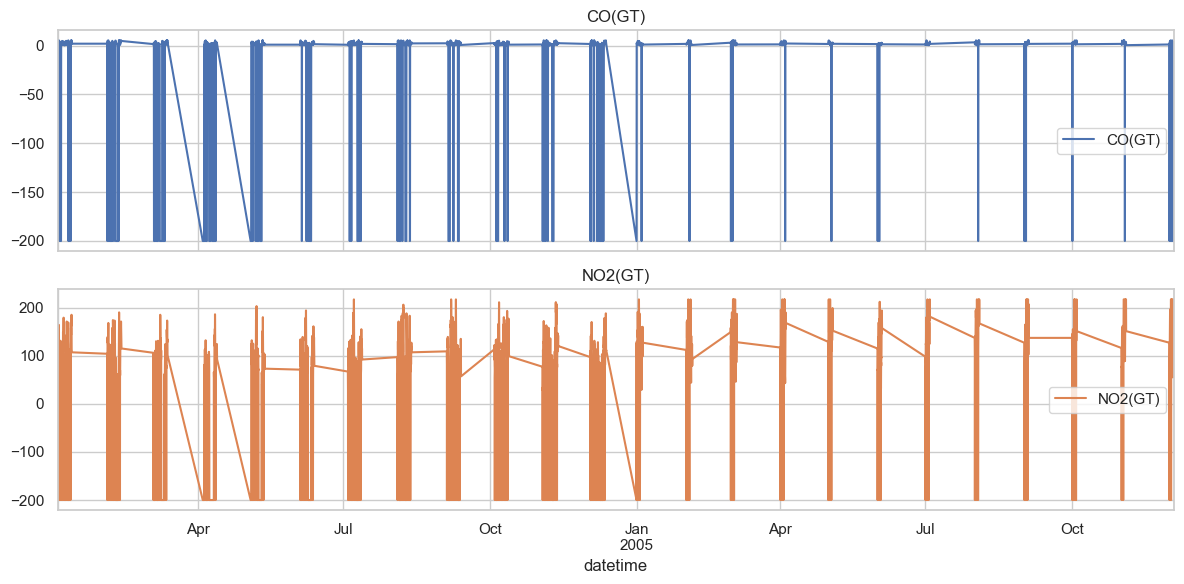

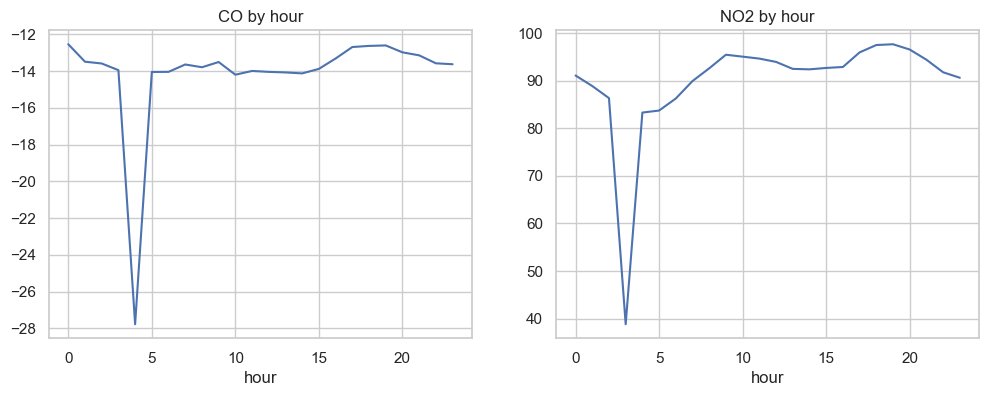

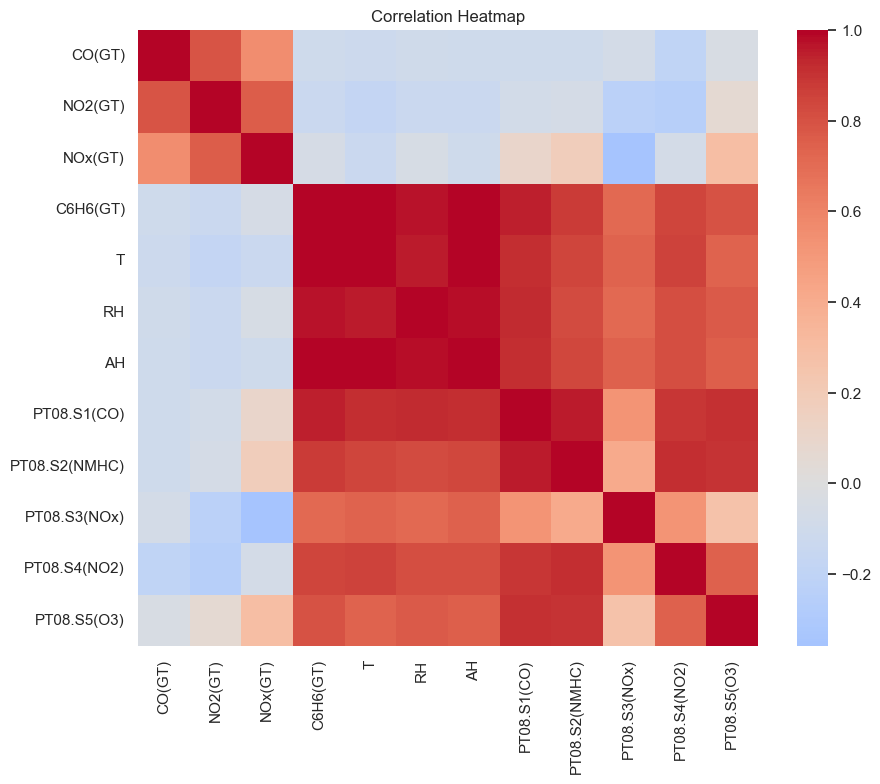

In [4]:

axs = df_h[['CO(GT)', 'NO2(GT)']].plot(subplots=True, figsize=(12,6), title=['CO(GT)','NO2(GT)'])
plt.tight_layout(); plt.show()

tmp = df_h.copy()
tmp['hour'] = tmp.index.hour
tmp['dow'] = tmp.index.dayofweek

fig, ax = plt.subplots(1,2, figsize=(12,4))
if 'CO(GT)' in tmp:
    tmp.groupby('hour')['CO(GT)'].mean().plot(ax=ax[0]); ax[0].set_title('CO by hour')
if 'NO2(GT)' in tmp:
    tmp.groupby('hour')['NO2(GT)'].mean().plot(ax=ax[1]); ax[1].set_title('NO2 by hour')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df_h.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap'); plt.show()


## 4) Feature Engineering

In [5]:

data = df_h.copy()
data['hour'] = data.index.hour
data['dow'] = data.index.dayofweek
data['month'] = data.index.month

LAGS = [1, 2, 3, 6, 12, 24]
for lag in LAGS:
    for col in ['CO(GT)', 'NO2(GT)']:
        if col in data.columns:
            data[f'{col}_lag{lag}'] = data[col].shift(lag)

data_ml = data.dropna().copy()
print("ML feature frame:", data_ml.shape)
data_ml.head()


ML feature frame: (16776, 27)


,CO(GT),NO2(GT),NOx(GT),C6H6(GT),T,RH,AH,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),hour,dow,month,CO(GT)_lag1,NO2(GT)_lag1,CO(GT)_lag2,NO2(GT)_lag2,CO(GT)_lag3,NO2(GT)_lag3,CO(GT)_lag6,NO2(GT)_lag6,CO(GT)_lag12,NO2(GT)_lag12,CO(GT)_lag24,NO2(GT)_lag24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-05 00:00:00,3.5,110.0,185.0,15.2,17.8,66.8,1.3460,1425.0,1155.0,709.0,1936.0,1789.0,0,0,1,2.0,103.0,2.0,113.0,2.5,124.0,4.2,132.0,1.7,73.0,1.6,86.0
2004-01-05 01:00:00,2.4,84.0,129.0,9.3,17.3,68.3,1.3346,1179.0,951.0,826.0,1724.0,1323.0,1,0,1,3.5,110.0,2.0,103.0,2.0,113.0,5.4,164.0,1.7,73.0,1.2,70.0
2004-01-05 02:00:00,1.6,71.0,85.0,6.5,16.5,70.2,1.3099,1047.0,833.0,939.0,1647.0,1081.0,2,0,1,2.4,84.0,3.5,110.0,2.0,103.0,4.9,161.0,1.7,72.0,1.1,55.0
2004-01-05 03:00:00,1.3,-200.0,-200.0,6.3,15.7,73.1,1.2902,1009.0,825.0,950.0,1629.0,938.0,3,0,1,1.6,71.0,2.4,84.0,3.5,110.0,2.5,124.0,1.9,81.0,0.9,-200.0
2004-01-05 04:00:00,-200.0,42.0,35.0,3.5,16.2,69.9,1.2756,882.0,685.0,1134.0,1492.0,673.0,4,0,1,1.3,-200.0,1.6,71.0,2.4,84.0,2.0,113.0,2.3,93.0,0.7,49.0


## 5) Time-Series Forecasting Models

### 5.1 SARIMAX (univariate with optional exogenous)

C:\Users\Shakhawat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


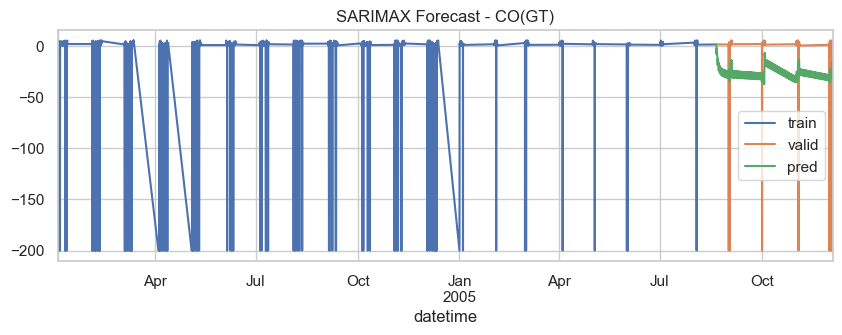

C:\Users\Shakhawat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


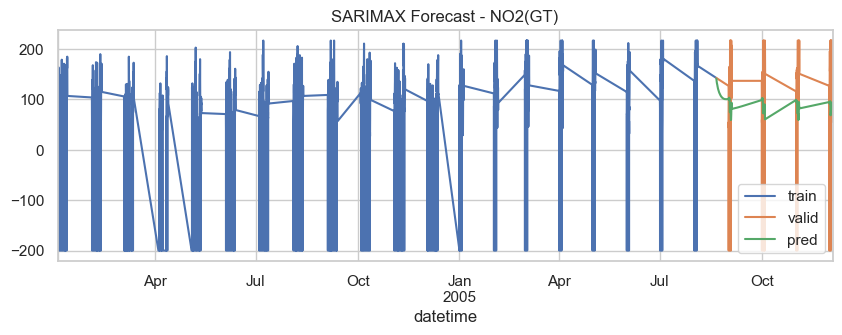

In [6]:

import warnings
warnings.filterwarnings('ignore')

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    have_sm = True
except Exception as e:
    print("statsmodels not available, skipping SARIMAX. Reason:", e)
    have_sm = False

models_sarimax = {}
preds_sarimax = {}

N_VAL = max(168, int(len(df_h)*0.15))
train = df_h.iloc[:-N_VAL].copy()
valid = df_h.iloc[-N_VAL:].copy()

targets = [c for c in ['CO(GT)', 'NO2(GT)'] if c in df_h.columns]

if have_sm:
    for tgt in targets:
        exog_cols = [c for c in ['T','RH','AH'] if c in df_h.columns]
        exog_train = train[exog_cols] if exog_cols else None
        exog_valid = valid[exog_cols] if exog_cols else None

        seasonal_period = 24  # hourly data
        order = (1,0,1)
        seasonal_order = (1,0,1,seasonal_period)

        try:
            sarimax = SARIMAX(train[tgt], order=order,
                               seasonal_order=seasonal_order,
                               exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
            res = sarimax.fit(disp=False)
            models_sarimax[tgt] = res
            preds = res.predict(start=valid.index[0], end=valid.index[-1], exog=exog_valid)
            preds_sarimax[tgt] = preds

            plt.figure(figsize=(10,3))
            train[tgt].plot(label='train'); valid[tgt].plot(label='valid')
            preds.plot(label='pred')
            plt.title(f'SARIMAX Forecast - {tgt}')
            plt.legend(); plt.show()
        except Exception as e:
            print(f"SARIMAX failed for {tgt}:", e)


### 5.2 Machine Learning Regressors (with lags & exogenous)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def time_split(dfX, dfy, val_ratio=0.15):
    n = len(dfX)
    n_val = max(168, int(n*val_ratio))
    X_tr, X_va = dfX.iloc[:-n_val], dfX.iloc[-n_val:]
    y_tr, y_va = dfy.iloc[:-n_val], dfy.iloc[-n_val:]
    return X_tr, X_va, y_tr, y_va

ml_results = {}
ml_preds = {}

for tgt in targets:
    feature_cols = [c for c in data_ml.columns if c != tgt]
    X_all = data_ml[feature_cols]
    y_all = data_ml[tgt]

    X_tr, X_va, y_tr, y_va = time_split(X_all, y_all, val_ratio=0.15)

    rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    p_va = pd.Series(rf.predict(X_va), index=X_va.index)

    ml_preds[tgt] = p_va
    mae = mean_absolute_error(y_va, p_va)
    rmse = mean_squared_error(y_va, p_va, squared=False)
    mape = (np.abs((y_va - p_va) / np.clip(np.abs(y_va), 1e-8, None))).mean() * 100.0
    ml_results[tgt] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    plt.figure(figsize=(10,3))
    y_all.iloc[-len(y_va):].plot(label='valid')
    p_va.plot(label='pred')
    plt.title(f'RandomForest Validation — {tgt}')
    plt.legend(); plt.show()

ml_results


## 6) Evaluation Metrics (MAE / RMSE / MAPE)

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

def eval_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))).mean() * 100.0
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

eval_table = []

if preds_sarimax:
    for tgt, pred in preds_sarimax.items():
        y_true = valid[tgt].reindex(pred.index).dropna()
        y_pred = pred.reindex(y_true.index).dropna()
        scores = eval_forecast(y_true, y_pred)
        scores['Model'] = 'SARIMAX'; scores['Target'] = tgt
        eval_table.append(scores)

for tgt, p in ml_preds.items():
    y_true = data_ml[tgt].reindex(p.index)
    scores = eval_forecast(y_true, p)
    scores['Model'] = 'RandomForest'; scores['Target'] = tgt
    eval_table.append(scores)

eval_df = pd.DataFrame(eval_table)
display(eval_df)

if not eval_df.empty:
    plt.figure(figsize=(8,4))
    piv = eval_df.pivot(index='Target', columns='Model', values='RMSE')
    piv.plot(kind='bar'); plt.title('RMSE by Target/Model'); plt.ylabel('RMSE'); plt.tight_layout(); plt.show()


## 7) Visualization and Insights

In [ ]:

future_forecasts = {}
if models_sarimax:
    steps = 24
    last_idx = df_h.index[-1]
    future_index = pd.date_range(start=last_idx + pd.Timedelta(hours=1), periods=steps, freq='H')
    for tgt in targets:
        try:
            model = models_sarimax[tgt]
            exog_cols = [c for c in ['T','RH','AH'] if c in df_h.columns]
            if exog_cols:
                last_exog = df_h[exog_cols].iloc[-1:]
                exog_future = pd.concat([last_exog]*steps, ignore_index=True)
                exog_future.index = future_index
            else:
                exog_future = None

            fc = model.predict(start=future_index[0], end=future_index[-1], exog=exog_future)
            future_forecasts[tgt] = fc

            plt.figure(figsize=(10,3))
            df_h[tgt].iloc[-7*24:].plot(label='history')
            fc.plot(label='forecast')
            plt.title(f'Next 24h Forecast — {tgt}')
            plt.legend(); plt.show()
        except Exception as e:
            print(f"Future forecast failed for {tgt}:", e)

insights = []
if 'CO(GT)' in df_h.columns:
    insights.append("High CO periods often align with traffic peaks; discourage idling and promote public transit during rush hours.")
if 'NO2(GT)' in df_h.columns:
    insights.append("Elevated NO₂ typically links to combustion sources; adjust urban traffic flow and encourage low-NOx technologies.")
if {'T','RH','AH'}.issubset(df_h.columns):
    insights.append("Meteorology impacts dispersion—during low wind/high RH, anticipate higher concentrations; plan alerts accordingly.")

print("Insights & Recommendations:")
for i, tip in enumerate(insights, 1):
    print(f"{i}. {tip}")
